# Initialized memories

VHDL memory initialization in VHDL can be tricky.

For reference, we check out a RAM implementation from the MaSoCist repository: 

In [1]:
! cd $HOME/work && [ -e masocist ] || git clone https://github.com/hackfin/masocist.git -b ghdl_1.0

In [2]:
%pushd
%cd ~/work/masocist/hdl/ram

/home/pyosys/work/masocist/hdl/ram


## Initialization with hex file

The RAM implementation to be examined is [dpram_init_ghdlsynth.vhdl](/edit/work/masocist/hdl/ram/dpram_init_ghdlsynth.vhdl)

Note: it is mandatory to use the VHDL 2008 standard flag to be able to use the `hread()` function.
First, we create a hex file:

In [3]:
f = open('/tmp/test.hex', 'w')
for i in range(1024):
    f.write("%04x\n" % i)
f.close()

We do the `synth_ecp5` run to see if this memory is properly inferred into a DP16KD:

In [4]:
! yosys -Q -m ghdl -p \
    'ghdl --std=08 -gADDR_W=10 -gDATA_W=16 -gINIT_HEX=/tmp/test.hex \
        ../libram.vhdl dpram_init_ghdlsynth.vhdl -e DPRAM_init_hex_ce; \
        synth_ecp5; stat' > /tmp/report.log 2>/dev/null

Let's see if a DP16KD was inferred:

In [5]:
! grep DP16KD /tmp/report.log 

Generating RTLIL representation for module `\DP16KD'.
  Checking rule #4 for bram type $__ECP5_DP16KD (variant 1):
    Metrics for $__ECP5_DP16KD: awaste=0 dwaste=2 bwaste=2048 waste=2048 efficiency=88
    Rule #4 for bram type $__ECP5_DP16KD (variant 1) accepted.
    Mapping to bram type $__ECP5_DP16KD (variant 1):
    Mapping to bram type $__ECP5_DP16KD failed.
  Checking rule #4 for bram type $__ECP5_DP16KD (variant 2):
    Metrics for $__ECP5_DP16KD: awaste=1024 dwaste=2 bwaste=11264 waste=11264 efficiency=44
    Rule #4 for bram type $__ECP5_DP16KD (variant 2) accepted.
    Mapping to bram type $__ECP5_DP16KD (variant 2):
    Mapping to bram type $__ECP5_DP16KD failed.
  Checking rule #4 for bram type $__ECP5_DP16KD (variant 3):
    Metrics for $__ECP5_DP16KD: awaste=3072 dwaste=0 bwaste=12288 waste=12288 efficiency=25
    Rule #4 for bram type $__ECP5_DP16KD (variant 3) accepted.
    Mapping to bram type $__ECP5_DP16KD (variant 3):
    Mapping to bram type $__ECP5_DP16KD failed.


## Initialization with parameter

The following memory block has a different interface. We can not use it as top module, we need to instance
its parameters through a parenting module. For convenience, we use a MyHDL ram wrapper.

In [6]:
from myhdl import *

import random

random.seed(26)

RANDOM_DATA = [ random.randrange(0, 0x10000) for _ in range(64) ]

def convert(data16):
    s = "("
    for d in data16[:-1]:
        s += 'x"%04x",' % d
    s += 'x"%04x")' % data16[-1]
    return s

@block
def ram_wrapper(a_clk, a_write, a_read, a_we, a_addr, \
                b_clk, b_write, b_read, b_we, b_addr):

    ADDR_W = len(a_addr)
    DATA_W = len(b_read)
    
    a_read.driven = 'wire'
    b_read.driven = 'wire'
    
    ram_init_data = convert(RANDOM_DATA) # Convert to VHDL string

    @instance
    def dummy():
        yield delay(1)
    
    return instances()

ram_wrapper.vhdl_code = \
"""
dpram_init_inst: entity work.dpramc2_init
    generic map(ADDR_W => $ADDR_W, DATA_W => $DATA_W, INIT_DATA => $ram_init_data)
    port map (a_clk => $a_clk, a_we => $a_we, a_addr => $a_addr, a_write => $a_write, a_read => $a_read,
              b_clk => $b_clk, b_we => $b_we, b_addr => $b_addr, b_write => $b_write, b_read => $b_read);

"""


class RAMport:
    def __init__(self, awidth, dwidth):
        self.clk = Signal(bool(0))
        self.we = Signal(bool(0))
        self.addr = Signal(modbv()[awidth:])
        self.write = Signal(modbv()[dwidth:])
        self.read = Signal(modbv()[dwidth:])

def convert_wrapper():
    a, b = [RAMport(6, 8) for _ in range(2)]
    
    ram_inst = ram_wrapper(a.clk, a.write, a.read, a.we, a.addr, \
                          b.clk, b.write, b.read, b.we, b.addr)
    
    ram_inst.convert('vhdl')
    ram_inst.convert('verilog', trace = True) # To create the cosim-testbench
    
convert_wrapper()

/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: a_clk
  category=ToVHDLWarning
/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: a_write
  category=ToVHDLWarning
/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: a_we
  category=ToVHDLWarning
/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: a_addr
  category=ToVHDLWarning
/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: b_clk
  category=ToVHDLWarning
/home/pyosys/.local/lib/python3.7/site-packages/myhdl-0.11-py3.7.egg/myhdl/conversion/_toVHDL.py:408: ToVHDLWarning: Port is not used: b_write
  category=ToVHDLWarning


This has now created a VHDL file, check it out: [ram_wrapper.vhd](/notebooks/work/masocist/hdl/ram/ram_wrapper.vhd)

To synthesis the VHDL file and collect the memories in one go, run:

In [7]:
! yosys -Q -m ghdl -p \
    'ghdl \
        ../libram.vhdl ram_wrapper.vhd pck_myhdl_011.vhd dpramc2_init.vhdl \
        -e ram_wrapper; \
        ls; memory_collect; \
        show -format dot -prefix meminit *' > /tmp/report2.log

dpramc2_init.vhdl:57:24:note: found RAM "ram", width: 8 bits, depth: 64


## Step wise integration

We run these steps via the Python API to be able to interactively execute commands.

**FIXME**: Output capture of `.run_pass` still broken. Must check jupyter VM console.

Make sure you've set the correct working directory:

In [8]:
%cd ~/work/masocist/hdl/ram

/home/pyosys/work/masocist/hdl/ram


Then we run the GHDL pass:

In [9]:
from pyosys import libyosys as ys
PLUGIN = "/usr/share/yosys/plugins/ghdl.so"
design = ys.Design()
ys.load_plugin(PLUGIN, [])

GHDL_PASS = """
ghdl ../libram.vhdl ram_wrapper.vhd pck_myhdl_011.vhd dpramc2_init.vhdl \
    -e ram_wrapper"""

ys.run_pass(GHDL_PASS, design)

Then we collect the memories:

In [10]:
ys.run_pass("memory_collect; stat", design)

Dump the design to a `.dot` file:

In [11]:
ys.run_pass("show -format dot -prefix meminit *", design)

# Display RTL (post 'memory collect')

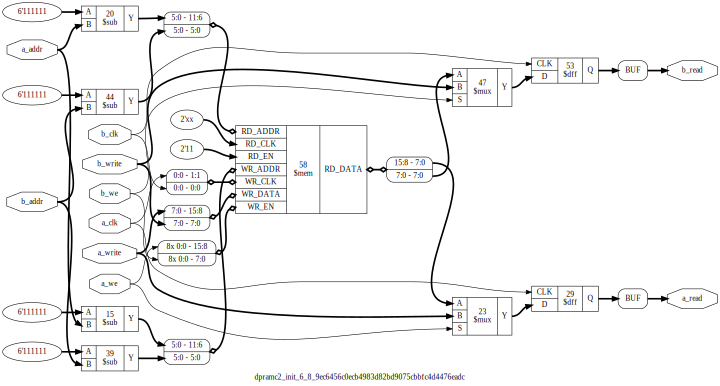

In [12]:
import graphviz
import pydotplus

graph = pydotplus.graphviz.graph_from_dot_file("meminit.dot")
g = graph[0]
g.set_size('"10,10"')
graphviz.Source(g.to_string())


### Elaboration on the RTL

* Currently inferred with an explicit DFF on the read ports

## Testing the memory

We write out this design to Verilog:

In [13]:
ys.run_pass("write_verilog ram_init_mapped.v", design)

In [14]:
%popd

/home/pyosys/work/tests
popd -> ~/work/tests


In [15]:
from ivl_cosim import *
from myhdl import *
LIBFILES = []
MASOCIST = "/home/pyosys/work/masocist/hdl/ram/"

@block
def ram_mapped_myhdl(a_clk, a_write, a_read, a_we, a_addr, \
                b_clk, b_write, b_read, b_we, b_addr):
    """MyHDL based RAM primitive mapping auxiliary"""
    
    signals = locals()
    
    mapped = "ram_init_mapped"
    tbname = "ram_wrapper"
    # We don't have this parameter ATM
    # params = { 'ADDR_W' : len(a.addr) }
    params = {}
    options = { 'name' : mapped, 'tbname' : tbname, 'libfiles' : LIBFILES} 
    return setupCosimulationIcarus(options, params, signals, MASOCIST)


In [16]:
@block
def testbench():
    a, b = [RAMport(6, 8) for _ in range(2)]
    clk = Signal(bool(0))
    ram_inst = ram_mapped_myhdl(a.clk, a.write, a.read, a.we, a.addr, \
                          b.clk, b.write, b.read, b.we, b.addr)

    @always(delay(10))
    def clkgen():
        clk.next = not clk
        
    @always_comb
    def assign():
        a.clk.next = clk
        b.clk.next = clk
    
    @instance
    def stimulus():
        a.addr.next = 0
        b.addr.next = 0
        yield clk.negedge

        for i in range(1, 12):
            a.addr.next = i
            b.addr.next = 32 - i
            yield clk.negedge # To make sure reading after valid outputs:
            print(b.read, a.read)
            if a.read != (RANDOM_DATA[i] & 0xff) or b.read != (RANDOM_DATA[32-i] & 0xff):
                raise ValueError("failed test, data mismatch")

        print("TEST COMPLETED")
        raise StopSimulation

    return instances()

tb = testbench()
tb.config_sim(name="/tmp/testbench", backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim()
tb.quit_sim()

['iverilog', '-s', 'tb_ram_wrapper', '-D', 'mixed_hdl', '-o', 'ram_init_mapped.o', '/home/pyosys/work/masocist/hdl/ram/ram_init_mapped.v', '/home/pyosys/work/masocist/hdl/ram/tb_ram_wrapper.v']
30 0a
ce 6b
6c 0f
92 78
bc 5a
ef 5e
70 de
a9 f4
40 22
8e 7a
c3 65
TEST COMPLETED


### Waveform display

In [17]:
import config
import wavedraw
import nbwavedrom

TB = "/tmp/testbench"

waveform = wavedraw.vcd2wave("/tmp/testbench.vcd", TB + '.clk')
    
nbwavedrom.draw(waveform)